<h1>Expander: Analytical Approximations for QSP/QSVT</h1><br>
<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

<h2><u>1. Introduction</u></h2>

`Expander` provides finite-order analytical expansions $\pi_d(x)$ for several functions used by QSP-based algorithms. These expansions are specified a Chebyshev polynomial basis, where it is assumed that the arguments satisfy $\vert x \vert \leq 1$.

The choice of an exact or optimizer-based (e.g., Remez) expansion is  problem-dependent.  For instance, the analytical Jacobi-Anger expansions for trigonometric functions are provably optimal - and are trivial to compute - making `Expander`  appropriate  when performing quantum simulation with QSP.  These expansions are  less suitable if we are interested in a matrix pseudoinverse.  In this case, we only have an exact expansion for $  g(x) = (1 - (1-x^2)^b)/x$, which is an approximation to the inversion polynomial $f(x) = x^{-1}$.  The former has relatively poor numerical performance in this application, making a Remez fit to $f(x)$ preferable for some practical applications.  Similar considerations apply in the context of exponential decay / imaginary time evolution. While $\exp[-\beta x]$ can be fit as an even-parity function, the analytical result includes both even- and odd-parity terms.  This leads to a more complex quantum circuit - doubling the gate depth - and thus the more suitable approach is problem-dependent.


<h2><u>2. General Use</u></h2>

Each polynomial approximation in `Expander` is provided by a dedicated method, which returns Chebyshev expansion coefficients at a desired precision of $\epsilon_0 = $ `eps0`.  The degree $d$ of this approximation is thus set the precision target. For instance, the expansion for a Gaussian $f(x) = \exp[-\alpha x^2]$ may be generated using the `gaussian(alpha,eps0)` method.

In [2]:

###
### General imports
###

import numpy                as np
import numpy.linalg         as nla
import scipy.linalg         as sla
import scipy.special        as sfn

from   IPython.display      import display, clear_output
import matplotlib.pyplot    as plt
import matplotlib_inline    as mpli

###
### Exapnder imports
###

from pyLIQTR.sim_methods.expander         import Expander
from pyLIQTR.utils.plot_helpers           import plot_func_error

###
### Ploting and text output settings
###

mpli.backend_inline.set_matplotlib_formats('svg')
plt.rcParams['text.usetex'] = False
np.set_printoptions(precision=2)


We begin by specifying parameters for the Gaussian, and then invoke the associated `Expander` method.

In [3]:

alpha = 10.0;   eps0  = 1e-6

p_gau = Expander()
p_gau.gaussian(alpha,eps0)


The resulting coefficients and the polynomial degree are stored within the resulting `p_gau` object.  For instance,

In [4]:
print("\nNumber of Coefficients (Degree + 1): \n\n", p_gau.N,"\n")
print("\nPolynomial Degree: \n\n", p_gau.deg,"\n")
print("\nPolynomial Parity: \n\n", p_gau.parity,"\n")
print("Polynomial Coefficients: \n\n",p_gau.coeffs,"\n")


Number of Coefficients (Degree + 1): 

 10 


Polynomial Degree: 

 9 


Polynomial Parity: 

 0 

Polynomial Coefficients: 

 [ 1.84e-01 -3.28e-01  2.36e-01 -1.39e-01  6.88e-02 -2.91e-02  1.07e-02
 -3.46e-03  9.99e-04 -2.60e-04] 



The polynomial may also be evaluated on a set of points `xpts`:

In [5]:

npts = 10;   xpts = np.linspace(-1.0,1.0,npts)

p_gau.eval(xpts)


array([-5.17e-06,  2.32e-03,  4.56e-02,  3.29e-01,  8.84e-01,  8.84e-01,
        3.29e-01,  4.56e-02,  2.32e-03, -5.17e-06])

An `Expander` object may be passed to the constructor for an `Angler`, permitting the direct generation of phases for a QSP sequence.


<br> 
<font size="5">🎉</font> <b>NOTE:</b> <i>The `Expander` class is derived from `ChebyshevPoly`, and consequently provides all of its methods for polynomial manipulation and evaluation.</i>

<hr><hr>
<h2><u>3. Function Reference and Examples</u></h2>
<hr><hr>

<h2>Exponential Decay</h2>

> <h3>Syntax:</h3>

> `exponential_decay_even(beta, epsilon)` - Even parity components<br>
`exponential_decay_odd(beta, epsilon)` - Odd parity components

> <h3>Definition:</h3>

> The exponentially decaying function $f(x) = \exp[-\beta x + 1]$ can be approximated on $D = [-1,1]$ using a Jacobi-Anger expansion,

> \begin{equation}
p_d(x) = e^{-\beta} \left[ I_0(\beta) + 2 \sum_{j=1}^d I_j(\beta) \, T_j(-x)  \right],
\end{equation}

> which gives $f(x)$ to the order of $\epsilon_0$ if the degree of the expansion satisfies $d = \lceil \sqrt{2\lceil\max[\beta e^2, \log(2/\epsilon_0)]\rceil} \sqrt{\log (4/\epsilon_0)}$.  Note that this approximation is of mixed parity in the Chebyshev coefficients.  Thus, when performing QSP, the even and odd parts must be implemented separately (e.g., $f(x) = f_\text{even}(x) + f_\text{odd} (x)$) and "summed" to give the full expansion.  This is analogous to how we  represent an exponential in a Hamiltonian simualtion sequence).

> <font size="5">🚫</font>  <b>WARNING:</b> <i>The Chebyshev terms in this expansion for $\exp[-\beta x + 1] $. take an argument of $-x$.  Be aware when passing arguments!</i>

> <h3>Example:</h3>

In [6]:

beta  = 10.0;         eps0  = 1e-6

p_expdec_even = Expander()
p_expdec_even.exponential_decay_even(beta,eps0)


p_expdec_odd = Expander()
p_expdec_odd.exponential_decay_odd(beta,eps0)


print("\nEven Chebyshev Coefficients:\n\n", p_expdec_even.coeffs)
print("\n")
print("Odd Chebyshev Coefficients:\n\n",  p_expdec_odd.coeffs)



Even Chebyshev Coefficients:

 [2.82e+03 4.56e+03 2.45e+03 8.99e+02 2.32e+02 4.38e+01 6.23e+00 6.86e-01
 6.01e-02 4.27e-03 2.50e-04 1.23e-05 5.13e-07 1.84e-08 5.72e-10 1.56e-11
 3.74e-13 8.00e-15 1.53e-16 2.63e-18 4.08e-20 5.77e-22 7.43e-24 8.77e-26]


Odd Chebyshev Coefficients:

 [5.34e+03 3.52e+03 1.55e+03 4.76e+02 1.05e+02 1.71e+01 2.13e+00 2.09e-01
 1.64e-02 1.06e-03 5.66e-05 2.56e-06 9.89e-08 3.30e-09 9.59e-11 2.45e-12
 5.55e-14 1.12e-15 2.03e-17 3.32e-19 4.91e-21 6.62e-23 8.16e-25 9.22e-27]


In [7]:

npts = 1000;   xpts = np.linspace(0.0,1.0,npts)

f_expdec            =  lambda x,beta : np.exp(-beta * x )
p_expdec_even_vals  =  p_expdec_even.eval(-xpts)
p_expdec_odd_vals   =  p_expdec_odd.eval(-xpts)
p_expdec_vals       =  (p_expdec_even_vals + p_expdec_odd_vals)

f_expdec_vals       =  f_expdec(xpts,beta)


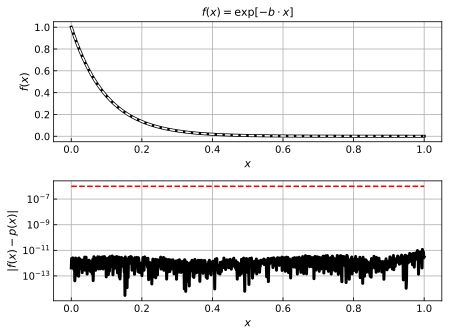

In [8]:
plot_func_error(xpts,f_expdec_vals,p_expdec_vals,eps0,"$f(x) = \exp[-b \cdot x]$")

<h2>Gaussian Function</h2>
<hr>

> <h3>Syntax:</h3>

> `gaussian(alpha, acc_tgt)`

> <h3>Definition:</h3>

> The Gaussian $f(x) = \exp[-\alpha x^2]$ may be approximated to the order of $\epsilon_0$ using an even-parity Chebyshev expansion,

> \begin{equation}
p(x) = e^{-\alpha/2} \left[ I_0 ( \alpha / 2 ) + 2 \sum_{j=1}^{d/2} (-1)^j \, I_j (\alpha/2) \, T_{2j}(x) \right],
\end{equation}

> provided that $d \sim O\Big(\big\lceil\sqrt{(\alpha + \log(1/\epsilon_0) \, \log(1/\epsilon_0)}\big\rceil\Big)$.


> <h3>Example:</h3>

In [9]:

alpha = 10.0
eps0  = 1e-6

#change to also take ("name",(args) )

p_gau = Expander()
p_gau.gaussian(alpha,eps0)


We can compare this to the target function:

In [10]:

npts = 1000;      xpts = np.linspace(-1.0,1.0,npts)

f_gau       =  lambda x,alpha : np.exp(-alpha * x**2)

p_gau_vals  =  p_gau.eval(xpts)
f_gau_vals  =  f_gau(xpts,alpha)


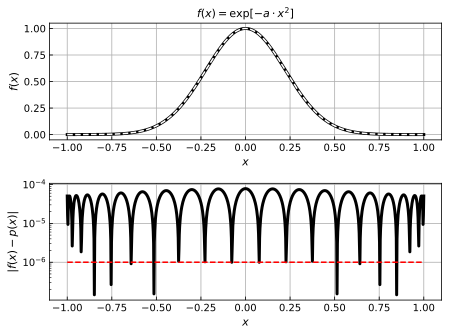

In [11]:
plot_func_error(xpts,f_gau_vals,p_gau_vals,eps0,"$f(x) = \exp[-a \cdot x^2]$")

<h2>Matrix Inversion (Pseudoinverse)</h2>

<h3>Syntax:</h3>

> `inverse(kappa, acc_tgt)`

<h3>Definition:</h3>

> This method approximates $f(x) = 1/x$ on the interval $[-1,1/\kappa] \cup [1/\kappa,1]$ using an odd extension

> \begin{equation}
g(x) = \frac{1 - (1-x^2)^b}{x}.
\end{equation}

> This can be computed to precision $\epsilon_0$ using the Chebyshev expansion

> \begin{equation}
f(x) = 4 \sum_{j=0}^d (-1)^j \frac{\sum_{i=j+1}^b \begin{pmatrix} 2b \\ b_i\end{pmatrix}}{2^{2b}} T_{2j + 1}(x)
\end{equation}

> where the brackets denote the usual convention for a binomial coefficient.  Here we take

<h3>Example:</h3>

In [12]:

kappa = 10.0
eps0  = 1e-4


p_inv = Expander()
p_inv.inverse(kappa,eps0)


In [13]:

npts  = 1000;      xpts = np.linspace(-1.0,1.0,npts)

f_inv       =  lambda x,kp,ep : ((1 - (1 - x**2)**np.ceil(kp**2 * np.log10(kp/ep)))/x)

p_inv_vals  =  p_inv.eval(xpts)
f_inv_vals  =  f_inv(xpts,kappa,eps0)


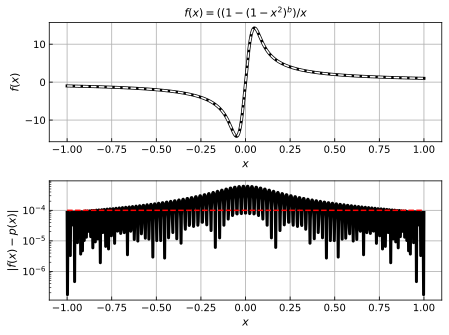

In [14]:
plot_func_error(xpts,f_inv_vals,p_inv_vals,eps0,"$f(x) = ((1 - (1-x^2)^b)/x$")

<h2>Trigonometric Expansions</h2>

<h3>Syntax:</h3> 

> `ja_cos(self, tau, epsilon)` <br>
`ja_sin(self, tau, epsilon)`

<h3>Definition:</h3>

> Trigonometric functions may be approximated using a conventional Jacobi-Anger expansion for the cosine (even parity) and sine (odd parity),

> \begin{split}
\frac{1}{2}\text{cos}(\tau \cdot x) &= J_0(\tau) + 2\sum_{k-1}^\infty (-1)^k J_{2k} (\tau) T_{2k}(x) \\
\frac{1}{2}\text{sin}(\tau \cdot x) &= 2 \sum_{k=0}^\infty (-1)^k J_{2k+1}(\tau) T_{2k+1}(x)
\end{split}

> where $J_k(x)$ and $T_k(x)$ are a Bessel function and a Chebyshev polynomial of the first kind, respectively (both of order $k$).  These give an error below $\epsilon_0$ if we take $d \geq e\vert \tau \vert/2 + \log_{10} (1/\epsilon_0)$.  

><b>NOTE:</b><i> The predominant use case for these expansions is in quantum simulation, where we encode a propagator $\exp[-\imath \tau x] = \cos(\tau x) + \imath \sin(\tau x)$ using controlled gates.  The factor of $1/2$ in the preceding expressions reflects this use case -- e.g., the coefficients provided by thie `ja_cos` and `ja_sin` functions enconde $\cos(\tau x)/2$ and $\sin(\tau x)/2$, respectively.</i>

<h3>Example:</h3>

In [15]:

tau      = 10.0
eps0     = 1e-6

npts = 1000;      xpts = np.linspace(-1.0,1.0,npts)

f_cos = lambda x,tau   : np.cos(tau*x)
f_sin = lambda x,tau   : np.sin(tau*x)

p_cos = Expander()
p_cos.ja_cos(tau,eps0)

p_sin = Expander()
p_sin.ja_sin(tau,eps0)

p_cos_vals = p_cos.eval(xpts)
p_sin_vals = p_sin.eval(xpts)

f_cos_vals = np.cos(tau*xpts)/2
f_sin_vals = np.sin(tau*xpts)/2


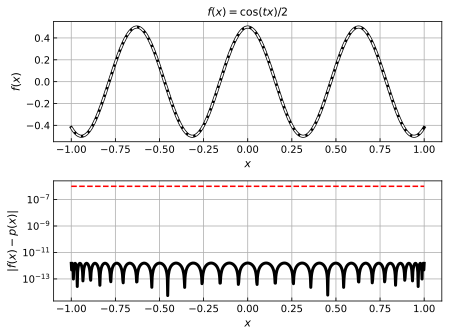

In [16]:
plot_func_error(xpts,f_cos_vals,p_cos_vals,eps0,"$f(x) = \cos(t x) / 2$")

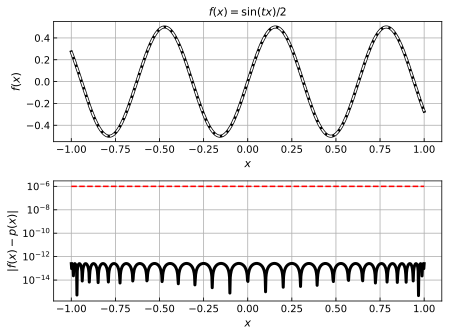

In [17]:
plot_func_error(xpts,f_sin_vals,p_sin_vals,eps0,"$f(x) = \sin(t x) / 2$")